In [1]:
import logging

import torch.nn as nn
import torch.optim as optim

import net.net as net
import net.io as io
import utils

import training.training as training
import training.utils as utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Configure root logger to show logs from all imported modules
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

# Remove any existing handlers to avoid duplicate logs
for handler in root_logger.handlers[:]:
    root_logger.removeHandler(handler)

# Add a stream handler with formatting
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root_logger.addHandler(handler)

# Also configure this module's logger
logger = logging.getLogger(__name__)

In [4]:
train_loader, val_loader = training.create_dataloaders(
    train_path="training/train_data_10000",
    val_path="training/val_data_10000",
    batch_size=2048,
    num_workers=8
)

/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


In [7]:
MODEL_CLASS = net.ExpandedGlideatorNet
MODEL_ARGS = {
    'weather_scaler': io.load_net('training/models/weather_scaler.pth'),
    'site_scaler': io.load_net('training/models/site_scaler.pth'),
    'num_launches': 251,
    'num_targets': 11,
    'site_embedding_dim': 32,
    'deep_hidden_units': [128, 64, 32],
    'parallel_deep_hidden_units': [128, 64, 32],
    'share_cross_net': False,
    'cross_layers': 2,
    'prediction_head_type': "multilabel"
}
OPTIMIZER_CLASS = optim.Adam
LR = 0.001
CRITERION = nn.BCELoss()
PERFECT_LOSS_THRESHOLD = 0.5
N_MAX_STEPS = 20_000

2025-05-09 13:39:24,471 - net.io - INFO - Loading neural network model from training/models/weather_scaler.pth
2025-05-09 13:39:24,480 - net.io - INFO - Neural network model successfully loaded from training/models/weather_scaler.pth
2025-05-09 13:39:24,481 - net.io - INFO - Loading neural network model from training/models/site_scaler.pth
2025-05-09 13:39:24,489 - net.io - INFO - Neural network model successfully loaded from training/models/site_scaler.pth


In [8]:
results = training.determine_n_steps_for_perfect_fit(
    model_class=MODEL_CLASS,
    model_args=MODEL_ARGS,
    optimizer_class=OPTIMIZER_CLASS,
    learning_rate=LR,
    criterion=CRITERION,
    train_loader=train_loader,
    perfect_loss_threshold=PERFECT_LOSS_THRESHOLD,
    max_steps_limit=N_MAX_STEPS
)

2025-05-09 13:39:28,933 - training.training - INFO - --- Starting Phase 1: Finding N (initial steps to reach loss <= 0.5) ---
2025-05-09 13:39:28,934 - training.training - INFO -     LR: 0.001, Max steps: 20000, Device: cpu
/mnt/c/Users/janhe/OneDrive/Plocha/repos/glideator/analytics/env-jl/lib/python3.10/site-packages/webdataset/autodecode.py:121: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add

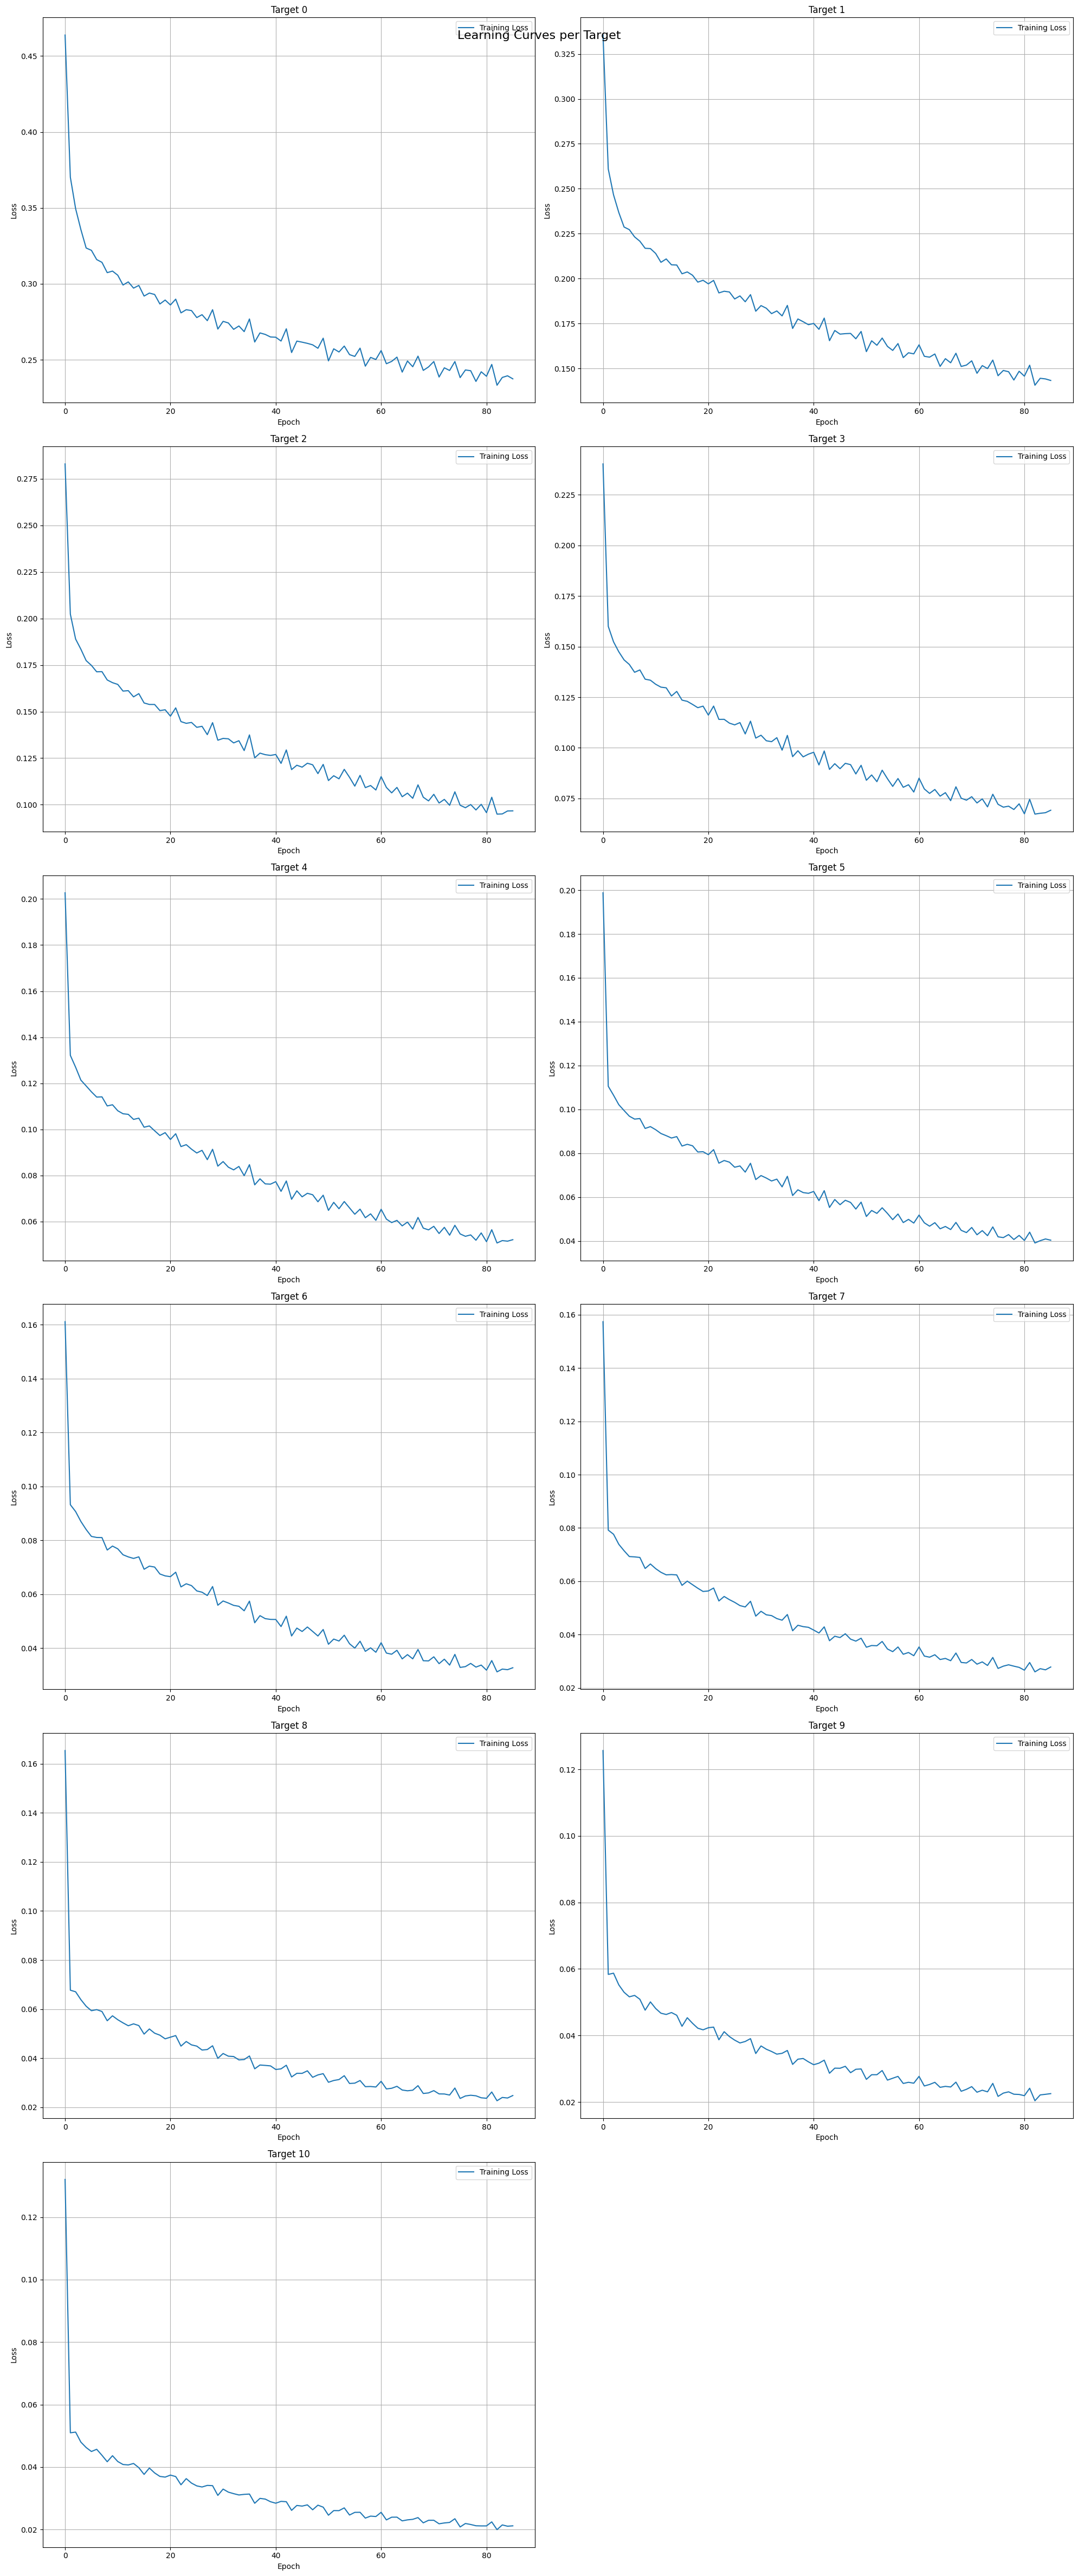

In [9]:
utils.plot_learning_curves_per_target(results['smoothed_per_target_loss_history'])

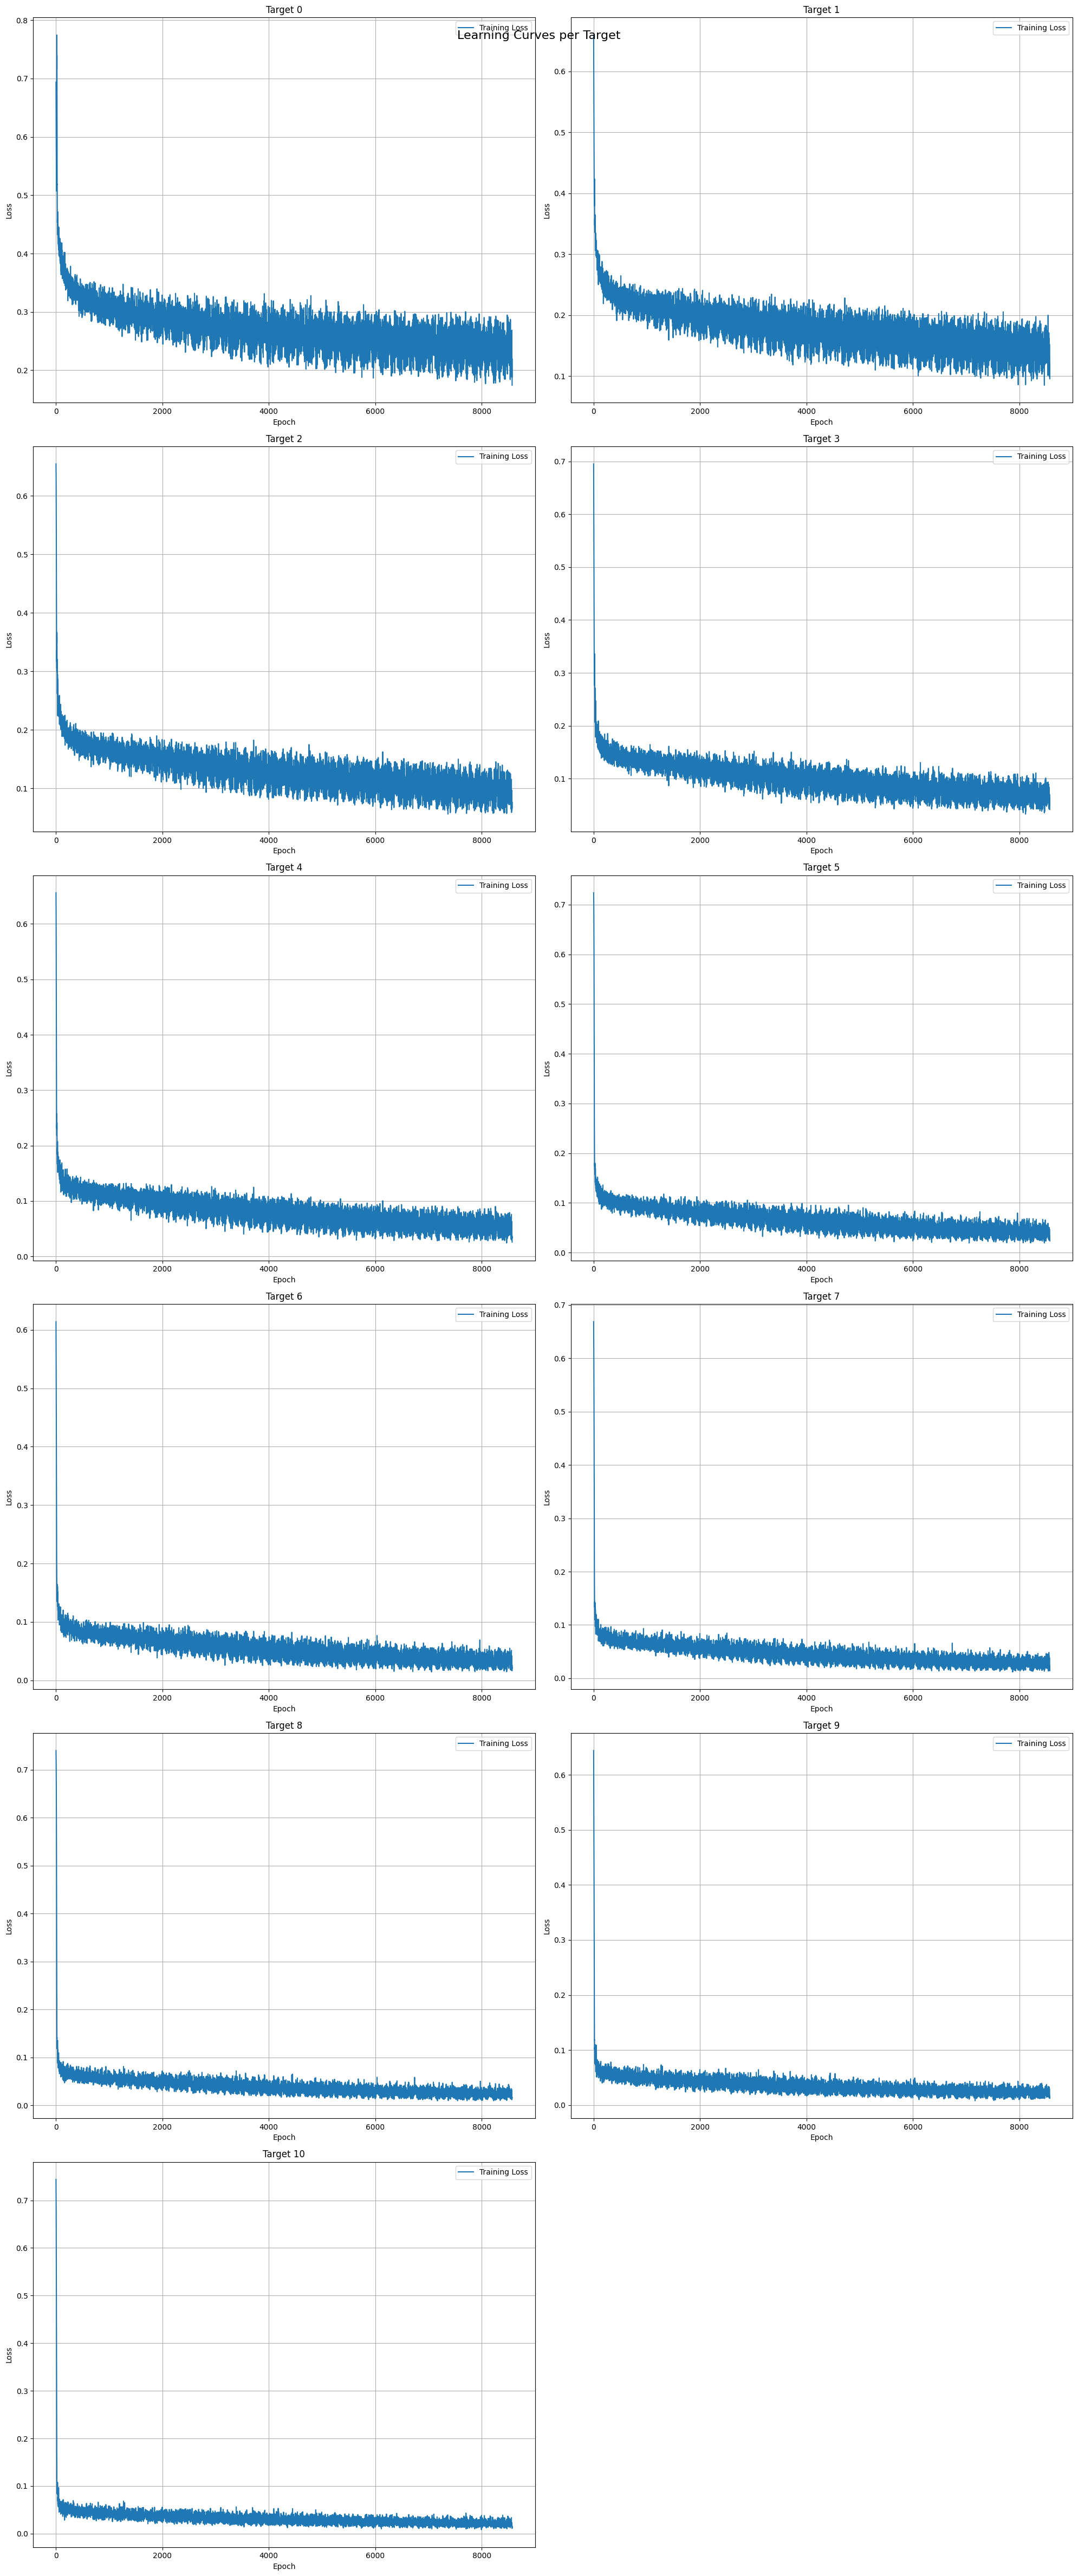

In [10]:
utils.plot_learning_curves_per_target(results['per_target_loss_history'])

In [11]:
LEARNING_RATES_FOR_SWEEP = [0.1, 0.01, 0.001, 0.0001]


In [12]:
sweep_results = training.sweep_learning_rates_for_min_steps(
    model_class=MODEL_CLASS,
    model_args=MODEL_ARGS,
    criterion=CRITERION,
    optimizer_class=OPTIMIZER_CLASS,
    train_loader=train_loader,
    learning_rates_for_sweep=LEARNING_RATES_FOR_SWEEP,
    N_max_steps=results['N_steps'], 
    perfect_loss_threshold= PERFECT_LOSS_THRESHOLD
)

2025-05-09 17:05:16,742 - training.training - INFO - --- Starting Phase 2: Learning Rate Sweep (each trial up to N=8574 steps) ---
2025-05-09 17:05:16,759 - training.training - INFO -     LRs to sweep: [0.1, 0.01, 0.001, 0.0001], Threshold: 0.5
2025-05-09 17:05:16,794 - training.training - INFO -     Testing LR: 1.0e-04 (Trial 1/4)
2025-05-09 17:07:58,724 - training.training - INFO -         LR 1.0e-04, Step 100/8574, Current Loss: 3.278245
2025-05-09 17:10:17,201 - training.training - INFO -         LR 1.0e-04, Step 200/8574, Current Loss: 1.901913
2025-05-09 17:12:53,408 - training.training - INFO -         LR 1.0e-04, Step 300/8574, Current Loss: 1.768108
2025-05-09 17:14:05,549 - training.training - WARNING -     Train loader exhausted for LR=0.0001. Resetting iterator.
2025-05-09 17:15:18,507 - training.training - INFO -         LR 1.0e-04, Step 400/8574, Current Loss: 1.834786
2025-05-09 17:17:50,263 - training.training - INFO -         LR 1.0e-04, Step 500/8574, Current Loss: 1.

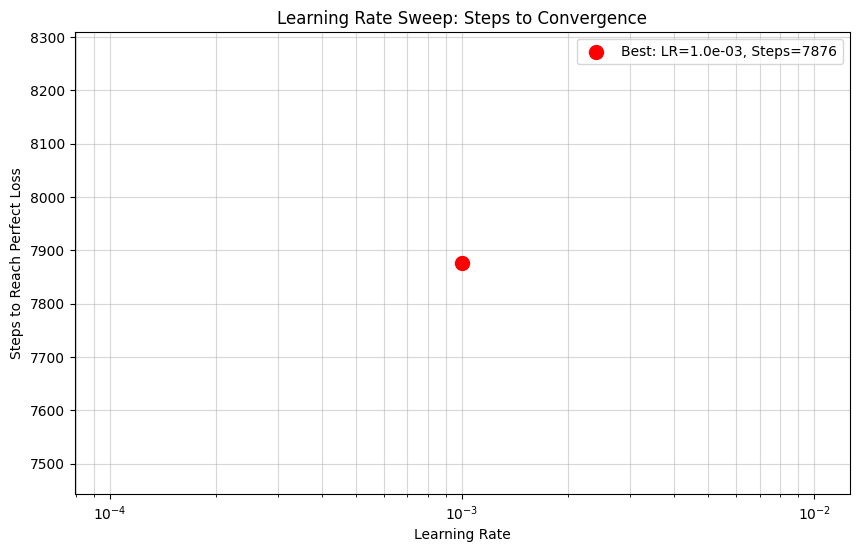

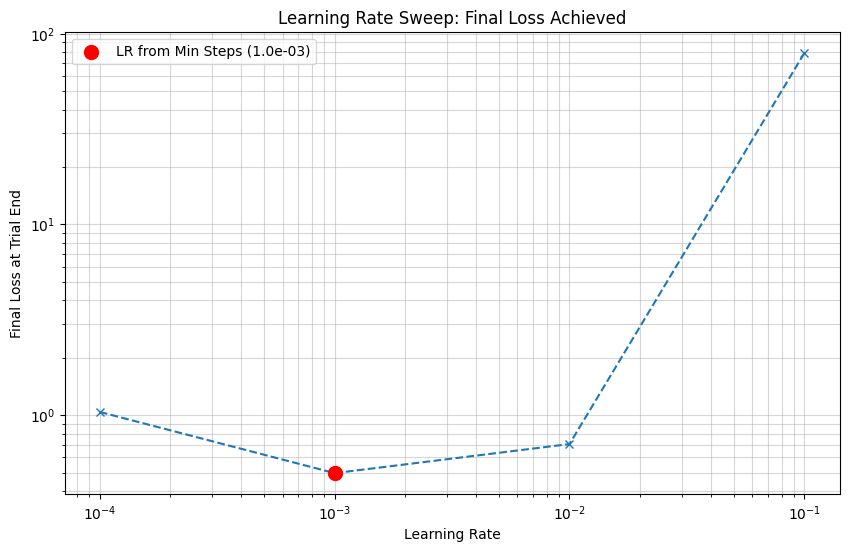


Summary of Sweep:
  LR: 1.0e-04, Steps to Perfect: -1, Final Loss: 1.039586
  LR: 1.0e-03, Steps to Perfect: 7876, Final Loss: 0.496877
  LR: 1.0e-02, Steps to Perfect: -1, Final Loss: 0.705747
  LR: 1.0e-01, Steps to Perfect: -1, Final Loss: 79.052734

Best LR found: 0.001
Min steps to perfect: 7876


In [13]:
import matplotlib.pyplot as plt

sweep_details = sweep_results['sweep_results']

# Extract data for plotting
learning_rates = [res['lr'] for res in sweep_details]
steps_to_perfect = [res['steps_to_perfect'] for res in sweep_details]
final_losses = [res['final_loss_at_trial_end'] for res in sweep_details]

# --- Plot 1: Learning Rate vs. Steps to Perfect ---
# Handle cases where steps_to_perfect might be -1 (if threshold not reached)
# You might want to decide how to represent this (e.g., plot at a high value, or filter out)
plottable_steps = []
plottable_lrs_for_steps = []
for lr, steps in zip(learning_rates, steps_to_perfect):
    if steps != -1: # Only plot if convergence was achieved
        plottable_lrs_for_steps.append(lr)
        plottable_steps.append(steps)

if plottable_lrs_for_steps:
    plt.figure(figsize=(10, 6))
    plt.plot(plottable_lrs_for_steps, plottable_steps, marker='o', linestyle='-')
    plt.xscale('log') # Learning rates often span orders of magnitude
    # plt.yscale('log') # Optional: if steps also vary widely
    plt.xlabel("Learning Rate")
    plt.ylabel("Steps to Reach Perfect Loss")
    plt.title("Learning Rate Sweep: Steps to Convergence")
    plt.grid(True, which="both", ls="-", alpha=0.5)
    
    # Highlight the best LR
    best_lr = sweep_results.get('best_lr')
    min_steps = sweep_results.get('min_steps_to_perfect')
    if best_lr is not None and min_steps != float('inf') and min_steps != -1:
        plt.scatter([best_lr], [min_steps], color='red', s=100, zorder=5, label=f'Best: LR={best_lr:.1e}, Steps={min_steps}')
        plt.legend()
        
    plt.show()
else:
    print("No learning rates reached the perfect loss threshold to plot 'Steps to Perfect'.")


# --- Plot 2: Learning Rate vs. Final Loss ---
# This plot is useful to see the final loss achieved by each LR,
# especially for those that didn't reach the 'perfect_loss_threshold'.
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, final_losses, marker='x', linestyle='--')
plt.xscale('log')
plt.yscale('log') # Losses are often best viewed on a log scale
plt.xlabel("Learning Rate")
plt.ylabel("Final Loss at Trial End")
plt.title("Learning Rate Sweep: Final Loss Achieved")
plt.grid(True, which="both", ls="-", alpha=0.5)

# Highlight the LR that resulted in the overall minimum steps (if it converged)
if best_lr is not None and min_steps != float('inf') and min_steps != -1:
    # Find the final loss for the best_lr
    final_loss_for_best_lr = None
    for res in sweep_details:
        if res['lr'] == best_lr:
            final_loss_for_best_lr = res['final_loss_at_trial_end']
            break
    if final_loss_for_best_lr is not None:
         plt.scatter([best_lr], [final_loss_for_best_lr], color='red', s=100, zorder=5, 
                     label=f'LR from Min Steps ({best_lr:.1e})')
         plt.legend()

plt.show()

print("\nSummary of Sweep:")
for res in sweep_details:
    print(f"  LR: {res['lr']:.1e}, Steps to Perfect: {res['steps_to_perfect']}, Final Loss: {res['final_loss_at_trial_end']:.6f}")

print(f"\nBest LR found: {sweep_results.get('best_lr', 'N/A')}")
print(f"Min steps to perfect: {sweep_results.get('min_steps_to_perfect', 'N/A')}")


In [15]:
LEARNING_RATES_FOR_SWEEP = [0.0005, 0.00075, 0.001, 0.0025, 0.005]

sweep_results_2 = training.sweep_learning_rates_for_min_steps(
    model_class=MODEL_CLASS,
    model_args=MODEL_ARGS,
    criterion=CRITERION,
    optimizer_class=OPTIMIZER_CLASS,
    train_loader=train_loader,
    learning_rates_for_sweep=LEARNING_RATES_FOR_SWEEP,
    N_max_steps=10_000, 
    perfect_loss_threshold= PERFECT_LOSS_THRESHOLD
)

2025-05-11 10:48:53,223 - training.training - INFO - --- Starting Phase 2: Learning Rate Sweep (each trial up to N=10000 steps) ---
2025-05-11 10:48:53,234 - training.training - INFO -     LRs to sweep: [0.0005, 0.00075, 0.001, 0.0025, 0.005], Threshold: 0.5
2025-05-11 10:48:53,285 - training.training - INFO -     Testing LR: 5.0e-04 (Trial 1/5)
2025-05-11 10:51:21,683 - training.training - INFO -         LR 5.0e-04, Step 100/10000, Current Loss: 1.739367
2025-05-11 10:53:46,672 - training.training - INFO -         LR 5.0e-04, Step 200/10000, Current Loss: 1.506181
2025-05-11 10:56:11,742 - training.training - INFO -         LR 5.0e-04, Step 300/10000, Current Loss: 1.534751
2025-05-11 10:57:22,740 - training.training - WARNING -     Train loader exhausted for LR=0.0005. Resetting iterator.
2025-05-11 10:58:37,022 - training.training - INFO -         LR 5.0e-04, Step 400/10000, Current Loss: 1.529244
2025-05-11 11:01:11,173 - training.training - INFO -         LR 5.0e-04, Step 500/1000

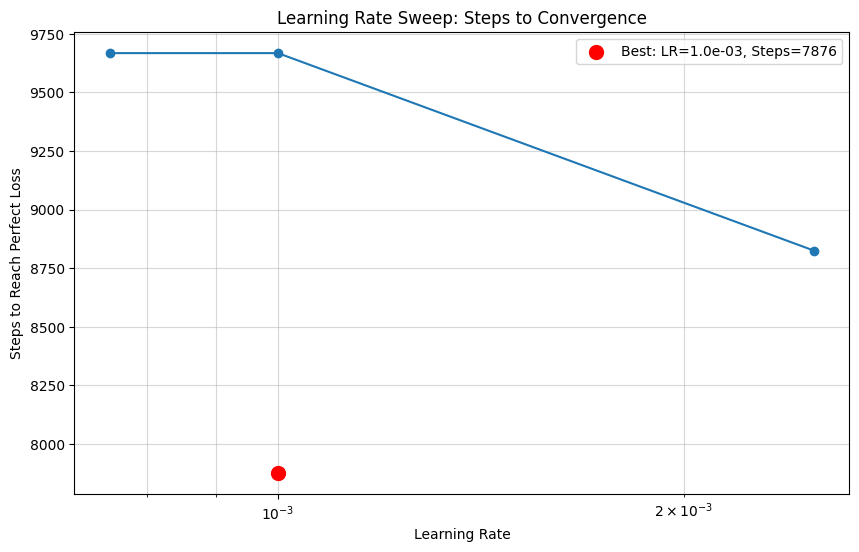

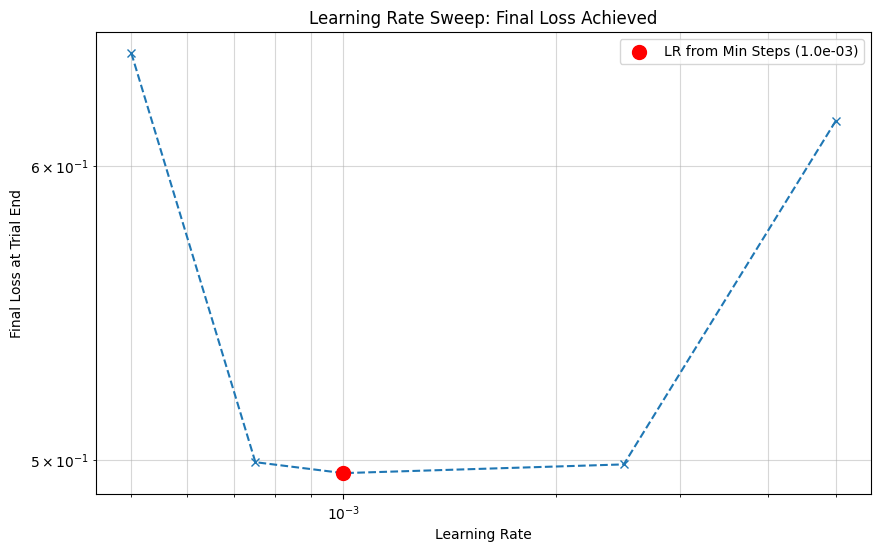


Summary of Sweep:
  LR: 5.0e-04, Steps to Perfect: -1, Final Loss: 0.643566
  LR: 7.5e-04, Steps to Perfect: 9668, Final Loss: 0.499267
  LR: 1.0e-03, Steps to Perfect: 9668, Final Loss: 0.495890
  LR: 2.5e-03, Steps to Perfect: 8825, Final Loss: 0.498583
  LR: 5.0e-03, Steps to Perfect: -1, Final Loss: 0.617134

Best LR found: 0.0025
Min steps to perfect: 8825


In [16]:
import matplotlib.pyplot as plt

sweep_details = sweep_results_2['sweep_results']

# Extract data for plotting
learning_rates = [res['lr'] for res in sweep_details]
steps_to_perfect = [res['steps_to_perfect'] for res in sweep_details]
final_losses = [res['final_loss_at_trial_end'] for res in sweep_details]

# --- Plot 1: Learning Rate vs. Steps to Perfect ---
# Handle cases where steps_to_perfect might be -1 (if threshold not reached)
# You might want to decide how to represent this (e.g., plot at a high value, or filter out)
plottable_steps = []
plottable_lrs_for_steps = []
for lr, steps in zip(learning_rates, steps_to_perfect):
    if steps != -1: # Only plot if convergence was achieved
        plottable_lrs_for_steps.append(lr)
        plottable_steps.append(steps)

if plottable_lrs_for_steps:
    plt.figure(figsize=(10, 6))
    plt.plot(plottable_lrs_for_steps, plottable_steps, marker='o', linestyle='-')
    plt.xscale('log') # Learning rates often span orders of magnitude
    # plt.yscale('log') # Optional: if steps also vary widely
    plt.xlabel("Learning Rate")
    plt.ylabel("Steps to Reach Perfect Loss")
    plt.title("Learning Rate Sweep: Steps to Convergence")
    plt.grid(True, which="both", ls="-", alpha=0.5)
    
    # Highlight the best LR
    best_lr = sweep_results.get('best_lr')
    min_steps = sweep_results.get('min_steps_to_perfect')
    if best_lr is not None and min_steps != float('inf') and min_steps != -1:
        plt.scatter([best_lr], [min_steps], color='red', s=100, zorder=5, label=f'Best: LR={best_lr:.1e}, Steps={min_steps}')
        plt.legend()
        
    plt.show()
else:
    print("No learning rates reached the perfect loss threshold to plot 'Steps to Perfect'.")


# --- Plot 2: Learning Rate vs. Final Loss ---
# This plot is useful to see the final loss achieved by each LR,
# especially for those that didn't reach the 'perfect_loss_threshold'.
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, final_losses, marker='x', linestyle='--')
plt.xscale('log')
plt.yscale('log') # Losses are often best viewed on a log scale
plt.xlabel("Learning Rate")
plt.ylabel("Final Loss at Trial End")
plt.title("Learning Rate Sweep: Final Loss Achieved")
plt.grid(True, which="both", ls="-", alpha=0.5)

# Highlight the LR that resulted in the overall minimum steps (if it converged)
if best_lr is not None and min_steps != float('inf') and min_steps != -1:
    # Find the final loss for the best_lr
    final_loss_for_best_lr = None
    for res in sweep_details:
        if res['lr'] == best_lr:
            final_loss_for_best_lr = res['final_loss_at_trial_end']
            break
    if final_loss_for_best_lr is not None:
         plt.scatter([best_lr], [final_loss_for_best_lr], color='red', s=100, zorder=5, 
                     label=f'LR from Min Steps ({best_lr:.1e})')
         plt.legend()

plt.show()

print("\nSummary of Sweep:")
for res in sweep_details:
    print(f"  LR: {res['lr']:.1e}, Steps to Perfect: {res['steps_to_perfect']}, Final Loss: {res['final_loss_at_trial_end']:.6f}")

print(f"\nBest LR found: {sweep_results_2.get('best_lr', 'N/A')}")
print(f"Min steps to perfect: {sweep_results_2.get('min_steps_to_perfect', 'N/A')}")


In [17]:
9000/300

30.0

: 